# An analysis of electrostatics of lactoferrin in bulk solution and in dimeric structure
_Björn Persson, Mikael Lund_

In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np, pandas as pd
import mdtraj as md
from math import sqrt, pi, exp
import os.path, os, sys, json, filecmp, copy
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir
print(workdir)

/lunarc/nobackup/users/mikael/github/faunus-notebooks/lactoferrin-dimer


## Contact map for lactoferrin dimer

In the following we will load a dimeric structure of lactoferrin as simulated using Metropolis Monte Carlo.
Based on the amino acid coordinates, we will calculate and plot a contact map between residues and also estimate their electrostatic interaction energies using a Yukawa potential and assuming 35 mM salt and pH 7.

In [2]:
def masscenter(atoms, positions):
    ''' center of mass for a set of atoms '''
    cm = [0,0,0] # residue mass center
    mw = 0       # residue weight
    for a in atoms:
        cm = cm + a.element.mass * positions[0][a.index]
        mw = mw + a.element.mass
    return cm / mw

def name2charge(resname):
    ''' return charge for residue name (pH 7) '''
    if (resname=="GLU"): return -1.0
    if (resname=="ASP"): return -1.0
    if (resname=="ARG"): return 1.0
    if (resname=="LYS"): return 1.0
    if (resname=="NTR"): return 1.0
    if (resname=="CTR"): return -1.0
    return 0.0

def energy(name1, name2, r2):
    ''' electrostatic energy (kT) '''
    r   = sqrt(r)
    lB  = 7.0
    lD  = 3.04/sqrt(0.035)
    eps = 0.05
    z1  = name2charge(name1)
    z2  = name2charge(name2)
    return lB*z1*z2/r*exp(-r/lD)

In [3]:
# open dimeric structure, atom detail
traj = md.open('ab.pdb')
top = traj.topology
traj.distance_unit

'angstroms'

In [4]:
# calculate distances between all residues and save those below 3.0 and 5.0 Ångstrom respectively
d1 = []   # r<5 Å
d2 = []   # u_elec < kT
d3 = []   # r<10 Å

lD = 3.04/sqrt(0.035) # Debye length
lB = 7 # Bjerrum length for water@300 K

chain1 = top.chain(0)
chain2 = top.chain(1)

for res1 in chain1.residues:
    cm1 = masscenter(res1.atoms, traj.positions)
    for res2 in chain2.residues:
        
        cm2 = masscenter(res2.atoms, traj.positions)
        r2 = np.linalg.norm(cm1-cm2) # squared distance
        qq = name2charge(res1.name) * name2charge(res2.name) # charge product

        if (qq<0):
            r = sqrt(r2)
            u = lB*qq/r * exp(-r/lD)
            if (u<-1.0):
                d3.append( [res1.index+1, res2.index-chain1.n_residues+1, r2, qq] )
        if (r2<5.0**2):
            d2.append( [res1.index+1, res2.index-chain1.n_residues+1, r2, qq] )
            if (r2<3.0**2):
                d1.append( [res1.index+1, res2.index-chain1.n_residues+1, r2, qq] )
                #print(res1.name + str(res1.index+1), res2.name+str(res2.index-chain1.n_residues+1), sqrt(r2))
        
d1=np.array(d1).T
d2=np.array(d2).T
d3=np.array(d3).T

d1[2] = np.sqrt(d1[2])
d2[2] = np.sqrt(d2[2])
d3[2] = np.sqrt(d3[2])

In [5]:
# append interaction energy, 'u', to pandas object
m = pd.DataFrame({'n1':d3[0], 'n2':d3[1], 'r':d3[2], 'qq':d3[3]})

lD = 3.04/sqrt(0.035) # Debye length
lB = 7 # Bjerrum length for water@300 K
eps= 0.0 # LJ scaling (kT)
m['u'] = lB * m.qq / m.r * np.exp(-m.r / lD) + 4*eps*( (6/m.r)**12 - (6/m.r)**6 )

m.head()

,n1,n2,qq,r,u
0,3.0,492.0,-1.0,4.901997,-1.056114
1,3.0,504.0,-1.0,3.925196,-1.400649
2,3.0,505.0,-1.0,3.925550,-1.400492
3,3.0,509.0,-1.0,4.200556,-1.286840
4,3.0,517.0,-1.0,4.584374,-1.151577


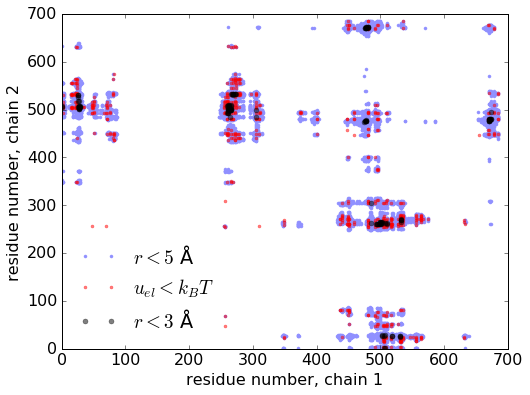

In [6]:
lightblue='#9090ff'
plt.plot(d2[0], d2[1], marker='.', color=lightblue, linestyle='none', label=u'$r < 5$ Å')
plt.plot(d3[0], d3[1], marker='.', color='red', linestyle='none', alpha=0.5, label='$u_{el}<k_BT$')
#plt.plot(d4[0], d4[1], marker='.', color='black', linestyle='none', alpha=0.5, label='$u_{vdw}<k_BT$')
plt.plot(d1[0], d1[1], 'k.', label=u'$r< 3$ Å', alpha=0.5, markersize=10)
plt.legend(loc=0, frameon=False)
plt.xlabel('residue number, chain 1')
plt.ylabel('residue number, chain 2')
plt.savefig('contactmap.pdf', bbox_inches='tight')

## Titration of dimeric structure

We now perform a continuum electrostatic titration of the dimeric complex using a background dielectric media with a coarse grained protein (amino acid level) and explit, grand canonical salt particles. Proton equilibria are handled through MC swap moves, coupled to the GC salt to ensure electroneutrality.

### Download and compile the MC software

In [7]:
%%bash -s "$workdir"
%cd -q $1

# the following lines are for compilation on LUNARC
module add GCC/5.4.0-2.26
module load CMake/3.5.2
export CXX=/sw/easybuild/software/Core/GCCcore/5.4.0/bin/g++
export CC=/sw/easybuild/software/Core/GCCcore/5.4.0/bin/gcc

if [ ! -d "faunus/" ]; then
    git clone https://github.com/mlund/faunus.git
    cd faunus
    git checkout a2220dc8f98606d2ceb42f14c6a08ec0723d8787
else
    cd faunus
fi

# if different, copy custom C++ program into faunus
if ! cmp ../titrate.cpp src/examples/gctit.cpp
then
    cp ../titrate.cpp src/examples/gctit.cpp
fi
pwd
cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=on &>/dev/null
make example_gctit -j4
%cd $1

/lunarc/nobackup/users/mikael/github/faunus-notebooks/lactoferrin-dimer/faunus
[ 36%] Built target xdrfile
[ 81%] Built target libfaunus
[100%] Built target example_gctit


bash: line 1: fg: no job control
bash: line 25: fg: no job control


### Simulation setup
Wall time, number of cores etc. Currently for the slurm system.

In [8]:
%%writefile submit.sh
#!/bin/bash
#SBATCH -N 1
#SBATCH -n 1
#SBATCH -t 03:00:00
../faunus/src/examples/gctit > out

Overwriting submit.sh


In [9]:
pH_range       = np.arange(1, 14, 0.2)
salt_range     = [0.035, 0.2]
protein_range  = ['dimer.pqr', 'cg-a.pqr']
print(pH_range)

[  1.    1.2   1.4   1.6   1.8   2.    2.2   2.4   2.6   2.8   3.    3.2
   3.4   3.6   3.8   4.    4.2   4.4   4.6   4.8   5.    5.2   5.4   5.6
   5.8   6.    6.2   6.4   6.6   6.8   7.    7.2   7.4   7.6   7.8   8.
   8.2   8.4   8.6   8.8   9.    9.2   9.4   9.6   9.8  10.   10.2  10.4
  10.6  10.8  11.   11.2  11.4  11.6  11.8  12.   12.2  12.4  12.6  12.8
  13.   13.2  13.4  13.6  13.8]


In [10]:
%cd -q $workdir

def mkinput():
    js = {
        "energy": {
            "eqstate": { "processfile": "titrate.json" },
            "nonbonded": {
                "coulomb": { "epsr": 80 }
            }
        },

        "system": {
            "temperature": 298.15,
            "sphere" : { "radius" : 90 },
            "mcloop": { "macro": 10, "micro": micro }
        },

        "moves": {
            "gctit"         : { "molecule": "salt", "prob": 0.9 },
            "atomtranslate" : {
                "salt":  { "prob": 0.1 }
            }
        },

        "moleculelist": {
            "protein":  { "structure": "../"+protein, "Ninit":1, "insdir":"0 0 0"},
            "salt": {"atoms":"Na Cl", "Ninit":60, "atomic":True }
        },
        
        "analysis": {
            "chargemultipole" : { "nstep":2, "mollist" : ["protein"] }
        },

        "atomlist" : {
            "Na"   :  { "q": 1, "r":1.9, "eps":0.005, "mw":22.99, "dp":100, "activity":salt },
            "Cl"   :  { "q":-1, "r":1.7, "eps":0.005, "mw":35.45, "dp":100, "activity":salt },
            "ASP"  :  { "q":-1, "r":3.6, "eps":0.05, "mw":110 },
            "HASP" :  { "q":0,  "r":3.6, "eps":0.05, "mw":110 },
            "LASP" :  { "q":2,  "r":3.6, "eps":0.05, "mw":110 },
            "CTR"  :  { "q":-1, "r":2.0, "eps":0.05, "mw":16 },
            "HCTR" :  { "q":0,  "r":2.0, "eps":0.05, "mw":16 },
            "GLU"  :  { "q":-1, "r":3.8, "eps":0.05, "mw":122 },
            "HGLU" :  { "q":0,  "r":3.8, "eps":0.05, "mw":122 },
            "LGLU" :  { "q":2,  "r":3.8, "eps":0.05, "mw":122 },
            "HIS"  :  { "q":0,  "r":3.9, "eps":0.05, "mw":130 },
            "HHIS" :  { "q":1,  "r":3.9, "eps":0.05, "mw":130 },
            "NTR"  :  { "q":0,  "r":2.0, "eps":0.05, "mw":14 },
            "HNTR" :  { "q":1,  "r":2.0, "eps":0.05, "mw":14 },
            "TYR"  :  { "q":-1, "r":4.1, "eps":0.05, "mw":154 },
            "HTYR" :  { "q":0,  "r":4.1, "eps":0.05, "mw":154 },
            "LYS"  :  { "q":0,  "r":3.7, "eps":0.05, "mw":116 },
            "HLYS" :  { "q":1,  "r":3.7, "eps":0.05, "mw":116 },
            "CYb"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":103 },
            "CYS"  :  { "q":-1, "r":3.6, "eps":0.05, "mw":103 },
            "HCYS" :  { "q":0,  "r":3.6, "eps":0.05, "mw":103 },
            "ARG"  :  { "q":0,  "r":4.0, "eps":0.05, "mw":144 },
            "HARG" :  { "q":1,  "r":4.0, "eps":0.05, "mw":144 },
            "ALA"  :  { "q":0,  "r":3.1, "eps":0.05, "mw":66 },
            "ILE"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":102 },
            "LEU"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":102 },
            "MET"  :  { "q":0,  "r":3.8, "eps":0.05, "mw":122 },
            "PHE"  :  { "q":0,  "r":3.9, "eps":0.05, "mw":138 },
            "PRO"  :  { "q":0,  "r":3.4, "eps":0.05, "mw":90 },
            "TRP"  :  { "q":0,  "r":4.3, "eps":0.05, "mw":176 },
            "VAL"  :  { "q":0,  "r":3.4, "eps":0.05, "mw":90 },
            "SER"  :  { "q":0,  "r":3.3, "eps":0.05, "mw":82 },
            "THR"  :  { "q":0,  "r":3.5, "eps":0.05, "mw":94 },
            "ASN"  :  { "q":0,  "r":3.6, "eps":0.05, "mw":108 },
            "GLN"  :  { "q":0,  "r":3.8, "eps":0.05, "mw":120 },
            "GLY"  :  { "q":0,  "r":2.9, "eps":0.05, "mw":54 }
        },

        "processes" : {
            "H-Asp" : { "bound":"HASP" , "free":"ASP" , "pKd":4.0  , "pX":pH },
            "H-Ctr" : { "bound":"HCTR" , "free":"CTR" , "pKd":2.6  , "pX":pH },
            "H-Glu" : { "bound":"HGLU" , "free":"GLU" , "pKd":4.4  , "pX":pH },
            "H-His" : { "bound":"HHIS" , "free":"HIS" , "pKd":6.3  , "pX":pH },
            "H-Arg" : { "bound":"HARG" , "free":"ARG" , "pKd":12.0 , "pX":pH },
            "H-Ntr" : { "bound":"HNTR" , "free":"NTR" , "pKd":7.5  , "pX":pH },
            "H-Cys" : { "bound":"HCYS" , "free":"CYS" , "pKd":10.8 , "pX":pH },
            "H-Tyr" : { "bound":"HTYR" , "free":"TYR" , "pKd":9.6  , "pX":pH },
            "H-Lys" : { "bound":"HLYS" , "free":"LYS" , "pKd":10.4 , "pX":pH }
        }
    }

    with open('titrate.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))

# flow control:
equilibration = True  # if true, delete state file and start over
production    = True   # if true, start from present state file
slurm         = True   # if true, submit production runs to slurm cluster
override      = False  # if true, override existing files

for protein in protein_range:    # loop over protein structures
    for salt in salt_range:      # loop over salt concentrations (activities)
        for pH in pH_range:      # loop over pH values

            # create/goto right directory
            pfx='pH'+str(pH)+'-I'+str(salt)+'-'+protein
            if not os.path.isdir(pfx):
                %mkdir -p $pfx
            else:
                if override==False:
                    break
            %cd $pfx

            # equilibration run
            if equilibration:
                !rm -fR state
                micro=5000
                mkinput()
                !../faunus/src/examples/gctit > eq 2>&1
                !rm -fR analysis_out.json

            # production run
            if production:
                micro=10000000
                mkinput()
                if slurm:
                    !sbatch ../submit.sh > /dev/null
                else:
                    !../faunus/src/examples/gctit > out 2>&1

            %cd -q ..
            #print('.', end='')

print('done.')

done.


### Charge analysis of dimer

First lets loop over salt and pH to read protein net charge and capacitance into a Pandas object. The simulation output can be accessed through the `analysis_out.json` file. When loaded, all data is saved in a pickle file that can be loaded later on in without needing the MC output.

In [11]:
%cd -q $workdir
import json

picklefile = 'titrationdata.p'          # titration data will be stored here

if os.path.isfile( picklefile ):        # if pickle file exists, use that
    print('loading from saved pickle')
    sets = pd.read_pickle( picklefile )
else:
    print('loading from MC raw data')   # otherwise extract from MC output
    sets = pd.Series()
    for protein in protein_range:
        data = {}
        for salt in salt_range:
            d = {}
            d['pH'] = pH_range
            d['Z'] = []
            d['C'] = []
            for pH in pH_range:

                pfx='pH'+str(pH)+'-I'+str(salt)+'-'+protein
                if os.path.isdir(pfx):
                    %cd -q $pfx            
                    results = json.load( open('analysis_out.json') )
                    j  = results['chargemultipole']['mollist']['protein']
                    Z  = j['Z']
                    Z2 = j['Z2']
                    d['Z'].append(Z)
                    d['C'].append(Z2-Z*Z)
                    %cd -q ..

            data[str(salt)] = d

        sets[protein] = pd.DataFrame(data) # convert to pandas object

    sets = pd.Series(sets)
    sets.to_pickle( picklefile )

sets['dimer.pqr']

loading from saved pickle


,0.035,0.2
C,"[10.4930502706, 12.9967668659, 15.0964382835, ...","[3.91310517029, 5.44401479272, 7.3092725181, 9..."
Z,"[196.06193488, 190.7147829, 184.14674446, 176....","[207.46585048, 205.26402702, 202.33784698, 198..."
pH,"[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, ...","[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, ..."


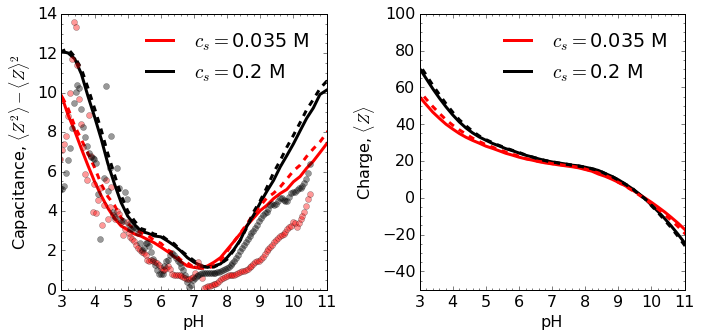

In [12]:
f = plt.figure(figsize=(10,5))

# load experimental -dZ/dpH
exp35  = np.loadtxt('capac-exp35mM.dat', unpack=True)
exp200 = np.loadtxt('capac-exp200mM.dat', unpack=True)

colors = {'0.2':'black', '0.035':'red'}

f.add_subplot(121)
for salt, d in sets['dimer.pqr'].iteritems():
    plt.plot(d.pH, 0.5*np.array(d.C), label=r'$c_s=$'+salt+' M', lw=3, color=colors[salt])

for salt, d in sets['cg-a.pqr'].iteritems():
    plt.plot(d.pH, d.C, lw=3, linestyle='--', color=colors[salt])
    plt.xlabel('pH')
    
plt.plot(exp35[0], exp35[1]/np.log(10), 'ro', alpha=0.4)
plt.plot(exp200[0], exp200[1]/np.log(10), 'ko', alpha=0.4)

plt.ylabel(r'Capacitance, $\langle Z^2 \rangle - \langle Z \rangle^2$')
plt.legend(loc=0, frameon=False)
plt.ylim((0,14))
plt.xlim((3,11))
plt.minorticks_on()

f.add_subplot(122)
for salt, d in sets['dimer.pqr'].iteritems():
    plt.plot(d.pH, 0.5*np.array(d.Z), label=r'$c_s=$'+salt+' M', lw=3, color=colors[salt])

for salt, d in sets['cg-a.pqr'].iteritems():
    plt.plot(d.pH, d.Z, lw=3, linestyle='--', color=colors[salt])

plt.xlabel('pH')
plt.ylabel(r'Charge, $\langle Z \rangle$')
plt.legend(loc=0, frameon=False)
plt.ylim((-50, 100))
plt.xlim((3,11))
plt.minorticks_on()

f.tight_layout()

plt.savefig('dimer-vs-monomer.pdf', bbox_inches='tight')

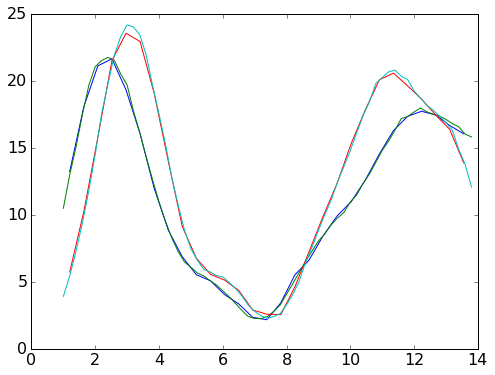

In [13]:
# Let's also calculate the capacitance from the derivative of
# the net-charge with respect to pH.
from scipy.interpolate import Akima1DInterpolator
for salt, d in sets['dimer.pqr'].iteritems():
    pH = np.linspace(d.pH.min(), d.pH.max(), 30)
    sZ = Akima1DInterpolator(d.pH, d.Z)(pH)
    sC = - np.diff(sZ) / np.diff(pH) / np.log(10)
    plt.plot(pH[:-1]+0.2, sC)
    plt.plot(d.pH, d.C)